Random Forest classifier and Ridge Classifer file
Corresponds with section 5 in paper
Author: Kyle Lane
University of Rochester

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [36]:
#cleaning up data, requires "dataframe.csv" to function
def read_data():
    
    data = pd.read_csv("dataframe.csv")
    data["dependencies"].fillna("", inplace=True)
    data["relevant_dependencies"].fillna("", inplace=True)
    data["dependencies"] = data["dependencies"].apply(lambda x: x.split("),"))
    data["relevant_dependencies"] = data["relevant_dependencies"].apply(lambda x: x.split("),"))
    data.drop('recommended_exclusion', axis=1, inplace=True)
    data.drop('sentence_id', axis=1, inplace=True)
    
    return data

#takes rows in dataframe and strips out everything we dont need. 
#we also create the dependency id's which will be used as 'words'
#this function is purposly bloated to allow for further development
def process_data(data):
    dataset = []
    feature_set = []
    typeCount = {}
    for i, (position, word, gerund, tags, dependencies, relDependencies, sentence) in data.iterrows():
        feature_set.append(gerund)
        feature_set.append(word)
        typeCount[gerund] = typeCount[gerund] + 1 if gerund in typeCount else 0   
        for dependency in relDependencies:
            if len(dependency.split())<3:
                continue
            id = dependency.split()[0]
            w1 = dependency.split()[1][1:-1].split("-")[0]
            p1 = dependency.split()[1][1:-1].split("-")[1]
            w2 = dependency.split()[2].split("-")[0]
            p2 = dependency.split()[2].split("-")[1]
            organized_dependency = (id, w1, p1, w2, p2)
            feature_set.append(organized_dependency)  
        dataset.append(feature_set)
        feature_set = []
    #print(typeCount) turn on to see ammount of each gerund type
    return dataset

#makes the binary feature array. each dependency is 0 unless present
def makeArray(item, dependencies):
    features = {"gerund": item[0]}
    features.update({f: 0 for f in dependencies})
    for feature in item[2:]:
        features[feature[0]] = 1
    return features

#counts num of each dependency, doubles as a set of dependencys if taken as keys
def count_identifiers(data):
    identifier_counts = {}
    for item in data:
        dependencies = item[2:]
        for dependency in dependencies:
            identifier = dependency[0]
            identifier_counts[identifier] = identifier_counts.get(identifier, 0) + 1
    return identifier_counts

In [37]:
data = read_data()
goodData = process_data(data)
dependencies = list(count_identifiers(goodData).keys())
dicts = [makeArray(s, dependencies) for s in goodData]

p_data = pd.DataFrame.from_dict(dicts)


In [38]:
#prints dependency counts for each type, very rough
grouped = p_data.groupby("gerund")
for name, group in grouped:
    print(f"Gerund: {name}")
    print(group.sum())

Gerund: acc-ing
gerund          acc-ingacc-ingacc-ingacc-ingacc-ingacc-ingacc-...
xcomp                                                         451
obj                                                          2516
advmod                                                        195
obl                                                          2246
advcl                                                         798
compound:prt                                                   52
conj                                                         1058
mark                                                           91
case                                                         1293
amod                                                          357
nmod                                                         1706
acl                                                          3067
punct                                                         436
ccomp                                                       

In [39]:
X = p_data.drop('gerund', axis=1)
y = p_data['gerund']


In [40]:
rf = RandomForestClassifier()
rf.fit(X, y)

# Extract feature importances
feature_importances = rf.feature_importances_


# Create a dictionary to store feature importances for each label
feature_importances_by_label = {}
for i, label in enumerate(y.unique()):
    feature_importances_by_label[label] = feature_importances[i]


In [41]:
# Print feature importances for each label, unused in report
for label, importance in feature_importances_by_label.items():
    print(label + ": " + str(importance))

vp-ing: 0.006445779890788835
ing-of: 0.01224143279125732
poss-ing: 0.006306840938228295
acc-ing: 0.01567894717782633
det-ing: 0.018798163619195975
poss-ing-of: 0.0014989810003235345


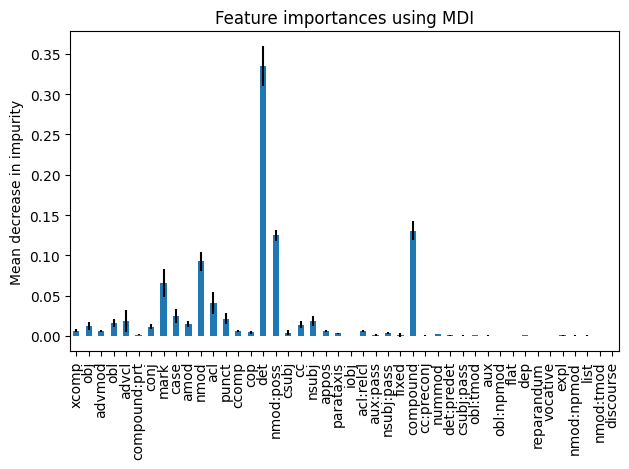

In [42]:
#MDI barchart
# referenced from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
forest_importances = pd.Series(feature_importances, index=dependencies)

fig, ax = plt.subplots()
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [43]:
clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X, y)

RidgeClassifier(solver='sparse_cg', tol=0.01)

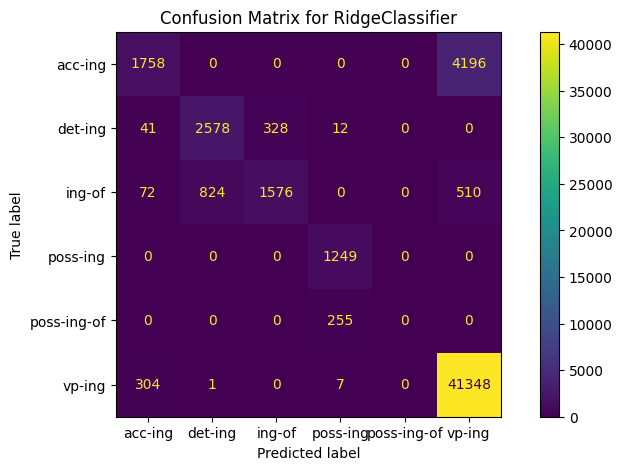

In [44]:
#confusion matrix
#referenced from https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py

pred = clf.predict(X)

lables = ["acc-ing","det-ing", "ing-of", "poss-ing", "poss-ing-of", "vp-ing"]

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y, pred, ax=ax)
ax.xaxis.set_ticklabels(lables)
ax.yaxis.set_ticklabels(lables)
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}"
)

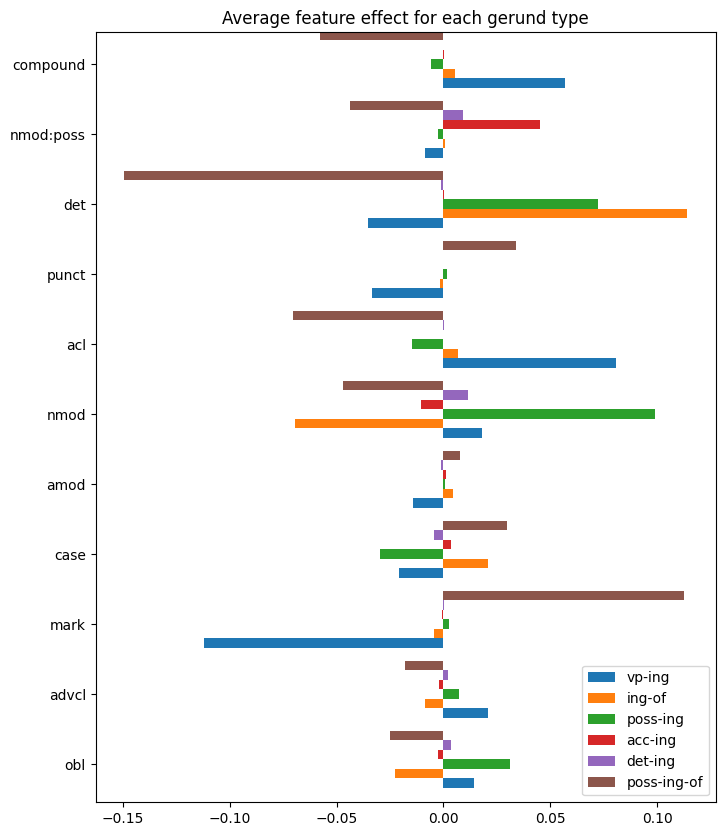

In [45]:
#barchart of feature importance by type
#referenced from https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py

def plot_feature_effects():
    # learned coefficients weighted by frequency of appearance
    average_feature_effects = clf.coef_ * np.asarray(X.mean(axis=0)).ravel()

    for i, label in enumerate(y.unique()):
        top5 = np.argsort(average_feature_effects[i])[-3:][::-1]
        if i == 0:
            top = pd.DataFrame(np.array(dependencies)[top5], columns=[label])
            top_indices = top5
        else:
            top[label] = np.array(dependencies)[top5]
            top_indices = np.concatenate((top_indices, top5), axis=None)
    top_indices = np.unique(top_indices)
    predictive_words = np.array(dependencies)[top_indices]

    # plot feature effects
    bar_size = 0.24
    padding = 0.80
    y_locs = np.arange(len(top_indices)) * (4 * bar_size + padding)

    fig, ax = plt.subplots(figsize=(8, 10))
    for i, label in enumerate(y.unique()):
        ax.barh(
            y_locs + (i - 2) * bar_size,
            average_feature_effects[i, top_indices],
            height=bar_size,
            label=label,
        )
    ax.set(
        yticks=y_locs,
        yticklabels=predictive_words,
        ylim=[
            0 - 4 * bar_size,
            len(top_indices) * (4 * bar_size + padding) - 4 * bar_size,
        ],
    )
    ax.legend(loc="lower right")


    return ax


_ = plot_feature_effects().set_title("Average feature effect for each gerund type")
